# Deepwalk Implementation


In [41]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch import tensor, Tensor
from utils.deepwalk import DeepwalkModel, train_deepwalk
from torch.multiprocessing import cpu_count
from sklearn.manifold import TSNE
import pandas as pd

Các Hyperparameter


In [42]:
EMBEDDING_SIZE = 64
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
START_LEARNING_RATE = 0.025
END_LEARNING_RATE = 0.001
# Tiền xử lý 1D embedding
PREPROCESS_WALKS_PER_VERTEX = 10
# Dùng cho TSNE
PERPLEXITY = 20

device và worker_threads


In [43]:
WORKER_THREADS = torch.cuda.device_count(
) if torch.cuda.is_available() else cpu_count()


WORKER_THREADS = 1


CHUNK_SIZE = 4


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)



print(WORKER_THREADS)

cpu
1


Load dataset


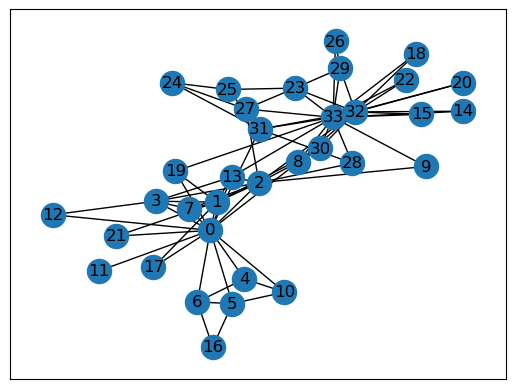

In [44]:
# Load dataset
# karate club
g: nx.Graph = nx.karate_club_graph()
adj_lists = [list(g.neighbors(v)) for v in g]
vertices = list(g)
V = len(g)
nx.draw_networkx(g)

### 1D Embedding

Embedding n-D bằng Deepwalk -> Embedding 1D bằng TSNE -> Sắp xếp lại thứ tự lá của Hierarchical Softmax


In [45]:
# ánh xạ từ đỉnh -> vị trí lá
leaf_pos = list(range(V))

# embedding sẽ được chuyển về 1 chiều bằng TSNE
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=(START_LEARNING_RATE + END_LEARNING_RATE) / 2.0,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=PREPROCESS_WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

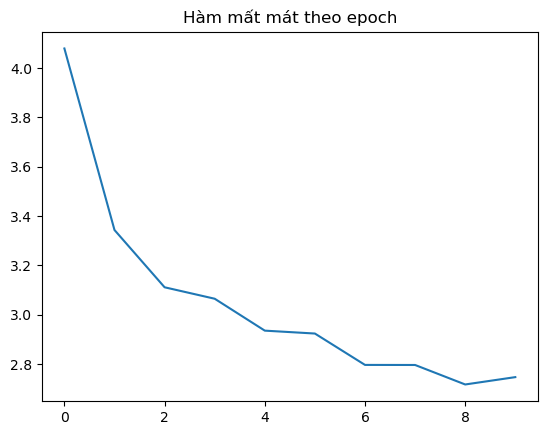

In [46]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

Chyển embedding về 1 chiều bằng TSNE rồi cập nhật lại vị trí lá cho Hierarchical Softmanx


In [47]:
# chuyển embedding về 1 chiều
emb: Tensor = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb = TSNE(n_components=1, perplexity=PERPLEXITY).fit_transform(emb).flatten()

# sắp xếp thứ tự các đỉnh
vertices.sort(key=lambda v: emb[v])

# cập nhật thứ tự lá cho các đỉnh
for pos, v in enumerate(vertices):
    leaf_pos[v] = pos

print(emb)
print(vertices)
print(leaf_pos)

[-1.2573363  -1.1696502  -1.3767538  -1.1513338  -1.9579719  -0.81589484
 -1.8497299  -0.80009824 -1.4236393  -1.7958071  -1.0427605  -0.00763398
 -2.368011   -1.3691489  -0.4892268  -0.49787295 -1.57118    -2.2992465
 -0.7429753  -1.6702867  -1.9757669  -1.9855993  -0.2069715  -1.0768245
 -2.5897787  -1.2184392  -2.725202   -0.2611692  -1.4718482  -0.39544836
 -2.1912386  -0.77291894 -1.7446355  -1.1008749 ]
[26, 24, 12, 17, 30, 21, 20, 4, 6, 9, 32, 19, 16, 28, 8, 2, 13, 0, 25, 1, 3, 33, 23, 10, 5, 7, 31, 18, 15, 14, 29, 27, 22, 11]
[17, 19, 15, 20, 7, 24, 8, 25, 14, 9, 23, 33, 2, 16, 29, 28, 12, 3, 27, 11, 6, 5, 32, 22, 1, 18, 0, 31, 13, 30, 4, 26, 10, 21]


### n-D Embedding


In [48]:
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=END_LEARNING_RATE,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

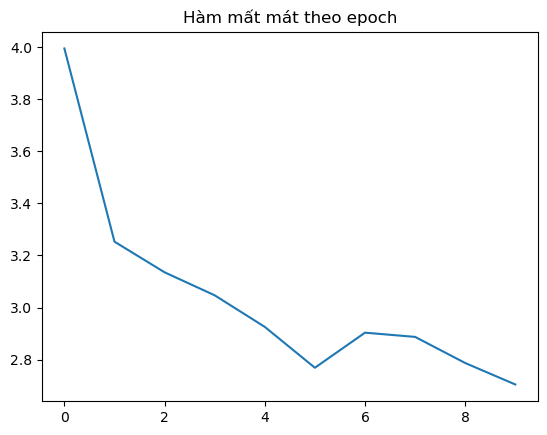

In [49]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

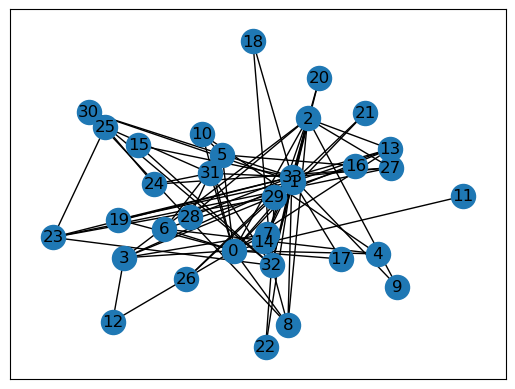

In [50]:
emb = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb_2d = TSNE(n_components=2, perplexity=PERPLEXITY).fit_transform(emb)
pos = {v: v_emb for v, v_emb in enumerate(emb_2d)}

nx.draw_networkx(g, pos)

In [51]:
df = pd.DataFrame(emb)
df.to_csv("out/karate_emb.csv", header=False, index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.887983,-1.050010,0.481539,-0.092787,-1.635961,1.102916,0.899132,0.340506,-0.696711,0.184125,...,-0.070054,0.535834,0.753540,0.441133,-0.619302,-0.436253,-0.868240,-0.296100,0.376042,0.612636
1,0.332420,-0.140132,0.983895,-0.824870,0.683341,0.822864,0.236152,-1.183101,-0.300332,0.269164,...,0.009838,0.055949,0.055216,0.116872,-0.371167,-1.171908,-0.704975,-0.266458,-1.245335,2.165565
2,-0.076480,0.283920,0.877694,-0.735555,2.072432,0.508067,-0.079428,0.017619,-1.783031,-1.695312,...,0.512473,-1.344552,0.292411,1.742799,0.101055,-0.235106,-0.330294,0.582775,-0.960041,0.548302
3,-0.433647,-0.657029,-1.216229,0.895604,0.969800,-1.099425,0.771262,-0.041681,-0.516868,0.830757,...,1.504025,1.614737,0.350283,1.285657,1.225226,-0.087180,-0.965596,0.853504,-0.860712,-0.618591
4,0.909824,-1.310938,0.282887,-1.586148,0.613238,0.466654,1.146057,0.011360,0.481737,-0.729720,...,1.103371,-1.440870,-0.614064,0.761745,0.315714,-0.998671,0.842372,-1.097545,1.105448,-0.149710
5,0.175743,-0.557203,-0.234400,-1.099326,0.660742,0.353093,-0.464377,0.616676,0.209053,0.624797,...,0.262469,0.583716,0.421050,-0.414280,-0.854704,0.726676,-1.209046,-1.516262,1.152606,1.075113
6,-0.564752,-0.521853,0.537514,0.747608,-0.270435,-1.826461,1.221323,0.276613,1.110347,0.618111,...,-2.114493,0.378001,-0.477530,-1.216452,-0.758011,1.496115,-0.376597,1.313199,-0.381165,-1.474533
7,-0.697548,0.215514,-0.234107,-0.621279,-0.980021,1.424505,0.064507,0.290008,0.623507,1.224188,...,0.240098,0.235241,-0.832098,-0.916502,-0.668357,0.129823,-1.266970,-0.975076,-0.273560,-1.487616
8,0.706044,-0.560033,0.522360,-0.994086,-0.651417,0.322290,0.785812,0.200527,0.515802,-0.825817,...,-1.149890,0.303350,-0.994794,-0.340912,-2.221541,-0.964971,1.442111,0.249443,0.302331,0.117520
9,-0.871684,-2.807922,0.216966,-0.812855,-1.148761,1.160211,-0.405512,-1.121094,2.186646,0.701583,...,1.163529,-0.753294,1.772964,-0.340445,1.027772,-0.026423,-0.236839,-0.267920,0.449395,-0.009064
